In [1]:
import cv2
import numpy as np

img = cv2.imread("/home/sophieguan/proj-pete/test_images/image1.jpg")
labels = []
with open("/home/sophieguan/proj-pete/test_images/image1.txt") as file:
    labels = np.asarray([line.rstrip().split() for line in file], dtype='f')

img2 = cv2.imread("/home/sophieguan/proj-pete/test_images/image2.jpg")
labels2 = []
with open("/home/sophieguan/proj-pete/test_images/image2.txt") as file:
    labels2 = np.asarray([line.rstrip().split() for line in file], dtype='f')

In [2]:
labels

array([[1.      , 0.572201, 0.380701, 0.492375, 0.137264],
       [2.      , 0.436632, 0.445396, 0.436125, 0.118042]], dtype=float32)

In [3]:
def get_coord(xc, yc, w, h, imw, imh):
    x1 = int((xc - w / 2) * imw)
    y1 = int((yc - h / 2) * imh)
    x2 = int((xc + w / 2) * imw)
    y2 = int((yc + h / 2) * imh)
    return x1, y1, x2, y2

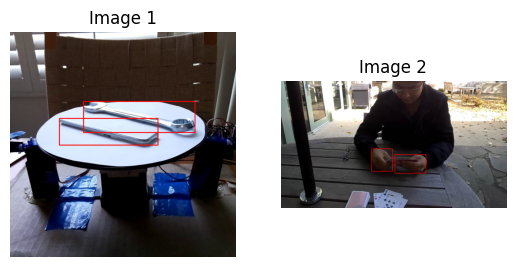

In [4]:
import matplotlib.pyplot as plt 

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for box in labels:
    x1, y1, x2, y2 = get_coord(box[1], box[2], box[3], box[4], img_rgb.shape[1], img_rgb.shape[0])
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

for box in labels2:
    x1, y1, x2, y2 = get_coord(box[1], box[2], box[3], box[4], img2_rgb.shape[1], img2_rgb.shape[0])
    cv2.rectangle(img2_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(img_rgb)
axes[0].axis('off')
axes[0].set_title('Image 1')

# Display the second image
axes[1].imshow(img2_rgb)
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.show()

In [28]:
import random
def cutmix(image, boxes, r_image, r_boxes):
        # https://github.com/WongKinYiu/ScaledYOLOv4/issues/254
        mixup_image = image.copy()
        imsize = min(image.shape[0], r_image.shape[0])
        x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
        x2, y2 = [int(random.uniform(imsize * 0.55, imsize * 1.0)) for _ in range(2)]
        
        mixup_boxes = r_boxes.copy()
        area = (r_boxes[:, 3] - r_boxes[:, 1]) * (r_boxes[:, 4] - r_boxes[:, 2])
        
        mixup_boxes[:, [1, 3]] = mixup_boxes[:, [1, 3]].clip(min=x1, max=x2)
        mixup_boxes[:, [2, 4]] = mixup_boxes[:, [2, 4]].clip(min=y1, max=y2)
        mixup_boxes = mixup_boxes.astype(np.int32)
        #cropped w, h, area
        w = mixup_boxes[:, 3] - mixup_boxes[:, 1]
        h = mixup_boxes[:, 4] - mixup_boxes[:, 2]
        area0 = w * h
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))
        
        mixup_boxes = mixup_boxes[np.where((w > 2) & (h > 2) & (area / (area0 + 1e-16) > 0) & (ar < 20))]
        mixup_image[y1:y2, x1:x2] = (mixup_image[y1:y2, x1:x2] + r_image[y1:y2, x1:x2])/2

        mixup_boxes = np.concatenate((boxes, mixup_boxes), axis=0)
        return mixup_image, mixup_boxes

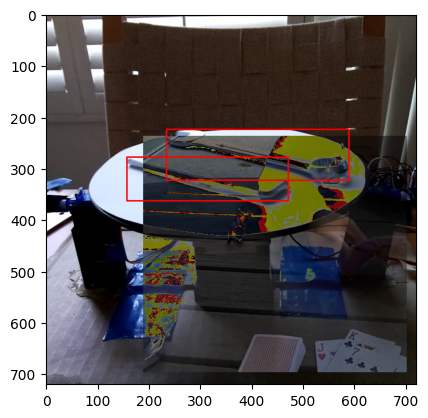

In [30]:
mixup_img, mixup_labels = cutmix(img, labels, img2, labels2)
img_rgb = cv2.cvtColor(mixup_img, cv2.COLOR_BGR2RGB)

for box in mixup_labels:
    x1, y1, x2, y2 = get_coord(box[1], box[2], box[3], box[4], img_rgb.shape[1], img_rgb.shape[0])
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

plt.imshow(img_rgb)
plt.show()